# RCNN-Implementation using Keras and OpenCV

1. Use OpenCVs Selective Search to get 2000 region proposals
1. Use Keras to build a CNN as the feature extractor (4096-D feature vector)

comparable to https://www.pyimagesearch.com/2020/07/13/r-cnn-object-detection-with-keras-tensorflow-and-deep-learning/ (without the fine-tuning part)

In [1]:
import os
import pandas as pd
from pathlib import Path
from time import time

import cv2
import numpy as np
from matplotlib import pyplot as plt

import keras
import tensorflow as tf
from keras import Model, optimizers
from keras.applications.vgg16 import VGG16
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense
from keras.models import load_model
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

In [2]:
def get_iou(bb1, bb2):
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']
    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])
    if x_right < x_left or y_bottom < y_top:
        return 0.0
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [13]:
train_images=[]
train_labels=[]
annotations = Path('./Airplanes_Annotations')
path = Path('./Airplane_images')
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

In [3]:
for num,i in enumerate(os.listdir(annotations)):
    try:
        if i.startswith("airplane"):
            filename = i.split(".")[0]+".jpg"
            print(num,filename)
            image = cv2.imread(os.path.join(path,filename))
            df = pd.read_csv(os.path.join(annotations,i))
            gtvalues=[]
            for row in df.iterrows():
                x1 = int(row[1][0].split(" ")[0])
                y1 = int(row[1][0].split(" ")[1])
                x2 = int(row[1][0].split(" ")[2])
                y2 = int(row[1][0].split(" ")[3])
                gtvalues.append({"x1":x1,"x2":x2,"y1":y1,"y2":y2})
            ss.setBaseImage(image)
            ss.switchToSelectiveSearchFast()
            ssresults = ss.process()
            imout = image.copy()
            counter = 0
            falsecounter = 0
            flag = 0
            fflag = 0
            bflag = 0
            for e,result in enumerate(ssresults):
                if e < 2000 and flag == 0:
                    for gtval in gtvalues:
                        x,y,w,h = result
                        iou = get_iou(gtval,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})
                        if counter < 30:
                            if iou > 0.70:
                                timage = imout[y:y+h,x:x+w]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(1)
                                counter += 1
                        else :
                            fflag = 1
                        if falsecounter <30:
                            if iou < 0.3:
                                timage = imout[y:y+h,x:x+w]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(0)
                                falsecounter += 1
                        else :
                            bflag = 1
                    if fflag == 1 and bflag == 1:
                        print("inside")
                        flag = 1
    except Exception as exc:
        print(exc)
        print("error in "+filename)
        continue

1 airplane_489.jpg
inside
2 airplane_304.jpg
inside
3 airplane_462.jpg
inside
4 airplane_476.jpg
inside
5 airplane_310.jpg
6 airplane_338.jpg
inside
7 airplane_660.jpg
8 airplane_106.jpg
inside
9 airplane_112.jpg
inside
10 airplane_674.jpg
11 airplane_648.jpg
inside
12 airplane_099.jpg
13 airplane_072.jpg
inside
14 airplane_066.jpg
inside
15 airplane_700.jpg
inside
17 airplane_270.jpg
inside
18 airplane_516.jpg
19 airplane_502.jpg
20 airplane_264.jpg
inside
21 airplane_258.jpg
inside
22 airplane_259.jpg
inside
23 airplane_503.jpg
24 airplane_265.jpg
inside
25 airplane_271.jpg
inside
26 airplane_517.jpg
28 airplane_067.jpg
inside
29 airplane_073.jpg
inside
30 airplane_098.jpg
31 airplane_649.jpg
32 airplane_113.jpg
33 airplane_675.jpg
34 airplane_661.jpg
35 airplane_107.jpg
inside
36 airplane_339.jpg
37 airplane_477.jpg
inside
38 airplane_311.jpg
inside
39 airplane_305.jpg
inside
40 airplane_463.jpg
41 airplane_488.jpg
inside
43 airplane_313.jpg
inside
44 airplane_475.jpg
45 airplane_46

inside
355 airplane_541.jpg
inside
356 airplane_555.jpg
inside
357 airplane_233.jpg
358 airplane_582.jpg
359 airplane_596.jpg
inside
360 airplane_019.jpg
362 airplane_025.jpg
inside
363 airplane_031.jpg
inside
365 airplane_179.jpg
inside
366 airplane_637.jpg
inside
367 airplane_151.jpg
inside
368 airplane_145.jpg
inside
369 airplane_623.jpg
inside
370 airplane_192.jpg
inside
371 airplane_186.jpg
inside
372 airplane_409.jpg
inside
373 airplane_353.jpg
inside
374 airplane_435.jpg
375 airplane_421.jpg
inside
376 airplane_347.jpg
inside
377 airplane_390.jpg
inside
378 airplane_384.jpg
inside
379 airplane_392.jpg
inside
380 airplane_386.jpg
inside
381 airplane_437.jpg
inside
382 airplane_351.jpg
383 airplane_345.jpg
inside
384 airplane_423.jpg
inside
385 airplane_379.jpg
inside
386 airplane_190.jpg
inside
387 airplane_184.jpg
388 airplane_153.jpg
inside
389 airplane_635.jpg
inside
390 airplane_621.jpg
inside
391 airplane_147.jpg
393 airplane_609.jpg
inside
394 airplane_027.jpg
395 airplane_

inside
692 airplane_644.jpg
inside
693 airplane_650.jpg
inside
694 airplane_136.jpg
inside
695 airplane_095.jpg
inside
696 airplane_081.jpg
inside
697 airplane_056.jpg
698 airplane_042.jpg
inside
699 airplane_297.jpg
inside
700 airplane_283.jpg
inside
702 airplane_268.jpg
703 airplane_532.jpg
704 airplane_254.jpg
inside
705 airplane_240.jpg
inside
706 airplane_526.jpg
inside
707 airplane_241.jpg
inside
708 airplane_527.jpg
inside
709 airplane_533.jpg
inside
710 airplane_255.jpg
inside
711 airplane_269.jpg
712 airplane_282.jpg
714 airplane_296.jpg
inside
715 airplane_043.jpg
inside
716 airplane_057.jpg
inside
717 airplane_080.jpg
inside
718 airplane_094.jpg
719 airplane_651.jpg
720 airplane_137.jpg
inside
721 airplane_123.jpg
inside
722 airplane_645.jpg
inside
723 airplane_679.jpg
724 airplane_692.jpg
725 airplane_686.jpg
inside
726 airplane_335.jpg
inside
727 airplane_453.jpg
728 airplane_447.jpg
inside
729 airplane_321.jpg
inside
730 airplane_309.jpg
inside
731 airplane_490.jpg
inside

In [5]:
X_new = np.array(train_images)
y_new = np.array(train_labels)

In [6]:
np.save("train_images", X_new)
np.save("train_labels", y_new)

In [3]:
X_new = np.load("train_images.npy")
y_new = np.load("train_labels.npy")

In [5]:
vggmodel = VGG16(weights='imagenet', include_top=True)

for layers in (vggmodel.layers)[:15]:
    print(layers)
    layers.trainable = False
last = vggmodel.layers[-2].output
predictions = Dense(2, activation="softmax")(last)
model_final = Model(vggmodel.input,predictions)
opt = Adam(lr=0.0001)
model_final.compile(loss = keras.losses.categorical_crossentropy, optimizer = opt, metrics=["accuracy"])
model_final.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [7]:
class OHELabelBinarizer(LabelBinarizer):
    def transform(self, y):
        Y = super().transform(y)
        if self.y_type_ == 'binary':
            return np.hstack((Y, 1-Y))
        else:
            return Y
    def inverse_transform(self, Y, threshold=None):
        if self.y_type_ == 'binary':
            return super().inverse_transform(Y[:, 0], threshold)
        else:
            return super().inverse_transform(Y, threshold)
lenc = OHELabelBinarizer()
Y =  lenc.fit_transform(y_new)
X_train, X_test , y_train, y_test = train_test_split(X_new,Y,test_size=0.1)

In [8]:
trdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)

traindata = trdata.flow(x=X_train, y=y_train)
tsdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
testdata = tsdata.flow(x=X_test, y=y_test)

In [9]:
BS = 10

checkpoint = ModelCheckpoint("rcnn_vgg16_1.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq=1)

early = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')

hist = model_final.fit(x=trdata.flow(x=X_train, y=y_train, batch_size=BS), steps_per_epoch=len(X_train) // BS, epochs= 35, validation_data=(X_test, y_test), callbacks=[checkpoint,early])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/35
10/10 [==============================] - 111s 11s/step - loss: 1.2896 - accuracy: 0.6938 - val_loss: 0.5464 - val_accuracy: 0.7188
Epoch 2/35
10/10 [==============================] - 97s 10s/step - loss: 0.4010 - accuracy: 0.8531 - val_loss: 0.3070 - val_accuracy: 0.8438
Epoch 3/35
10/10 [==============================] - 95s 9s/step - loss: 0.3033 - accuracy: 0.8844 - val_loss: 0.2895 - val_accuracy: 0.9062
Epoch 4/35
10/10 [==============================] - 96s 10s/step - loss: 0.2805 - accuracy: 0.9031 - val_loss: 0.2978 - val_accuracy: 0.9219
Epoch 5/35
10/10 [==============================] - 97s 10s/step - loss: 0.2704 - accuracy: 0.9062 - val_loss: 0.2341 - val_accuracy: 0.9062
Epoch 6/35
10/10 [==============================] - 103s 10s/step - loss: 0.3761 - accuracy: 0.8938 - val_loss: 0.2388 - val_accuracy: 0.8594
Epoch 7/35
10/10 [==============================] - 110s 11s/step - loss: 0.2

In [11]:
saved_model = load_model('rcnn_vgg16_1.h5')

112.23937773704529


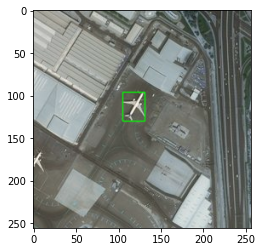

In [20]:
z = 0
for ind, i in enumerate(os.listdir(path)):
    if i.startswith("4"):
        z += 1
        img = cv2.imread(os.path.join(path,i))
        ss.setBaseImage(img)
        ss.switchToSelectiveSearchFast()
        ssresults = ss.process()
        imout = img.copy()
        start = time()
        for pos, result in enumerate(ssresults):
            if pos < 2000:
                x,y,w,h = result
                timage = imout[y:y+h,x:x+w]
                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                img = np.expand_dims(resized, axis=0)
                out = model_final.predict(img)
                if out[0][0] > 0.70:
                    cv2.rectangle(imout, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
        print(time() - start)
        plt.figure()
        plt.imshow(imout)
        if z > 5:
            break

In [30]:
predictions = model_final.predict(x=X_test.astype("float32"), batch_size=BS)

print(classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.93      0.88      0.90      1698
           1       0.91      0.94      0.93      2086

    accuracy                           0.92      3784
   macro avg       0.92      0.91      0.91      3784
weighted avg       0.92      0.92      0.92      3784



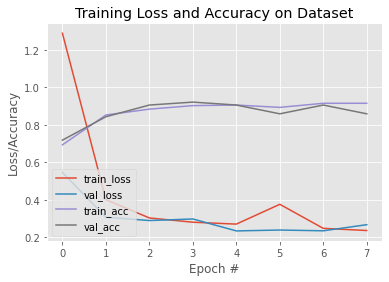

In [22]:
N = np.arange(0, 8)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, hist.history["loss"], label="train_loss")
plt.plot(N, hist.history["val_loss"], label="val_loss")
plt.plot(N, hist.history["accuracy"], label="train_acc")
plt.plot(N, hist.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()